# Copyright Netherlands eScience Center <br>
** Function     : Lead/lag regression of climate patterns on oceanic meridional energy transport (ORAS4,GLORYS2V3,SODA3) ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.06 ** <br>
** Last Update  : 2019.04.06 ** <br>
Description     : The code aims to regress non-climatological fields on the oceanic
                  meridional energy transport calculated from different oceanic
                  reanalysis datasets. In this, case, this includes GLORYS2V3
                  from Mercator Ocean, ORAS4 from ECMWF, and SODA3 from University
                  of Maryland & TAMU.<br>

Return Value    : NetCFD4 data file<br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging<br>
variables       : Meridional Energy Transport E [Tera-Watt] <br>
Caveat!!        : Spatial and temporal coverage<br>
                  Atmosphere<br>
                  ERA-Interim   1979 - 2016<br>
                  MERRA2        1980 - 2016<br>
                  JRA55         1979 - 2015<br>
                  Ocean<br>
                  GLORYS2V3     1993 - 2014<br>
                  ORAS4         1958 - 2014<br>
                  SODA3         1980 - 2015<br>
                  NEMO ORCA0083 1979 - 2012<br>
                  The full dataset of ORAS4 is from 1958. However, a quality report from
                  Magdalena from ECMWF indicates the quality of data for the first
                  two decades are very poor. Hence we use the data from 1979. which
                  is the start of satellite era.<br>
                  The full dataset of ORAS4 is from 1958.<br>
                  Data from 20N - 90N are taken into account!<br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
# specify data path
# OMET
datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
datapath_GLORYS2V3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3/postprocessing'
datapath_SODA3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3/postprocessing'
# target fields for regression
datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
# specify output path for figures
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/ESD/figures/regression_SH'
# index of latitude for insteret

In [4]:
# There is a cut to JRA, too
# index of latitude for insteret
# 20N
lat_ORAS4_20 = 181
lat_GLORYS2V3_20 = 579
lat_SODA3_20 = 569
# after a cut to 20-90 N
lat_ORAS4_20_cut = 1
lat_GLORYS2V3_20_cut = 0
lat_SODA3_20_cut = 0

# 30N
lat_ORAS4_30 = 192
lat_GLORYS2V3_30 = 623
lat_SODA3_30 = 613
# after a cut to 20-90 N
lat_ORAS4_30_cut = 12
lat_GLORYS2V3_30_cut = 44
lat_SODA3_30_cut = 44

# 40N
lat_ORAS4_40 = 204
lat_GLORYS2V3_40 = 672
lat_SODA3_40 = 662
# after a cut to 20-90 N
lat_ORAS4_40_cut = 24
lat_GLORYS2V3_40_cut = 93
lat_SODA3_40_cut = 93

# 50N
lat_ORAS4_50 = 218
lat_GLORYS2V3_50 = 726
lat_SODA3_50 = 719
# after a cut to 20-90 N
lat_ORAS4_50_cut = 38
lat_GLORYS2V3_50_cut = 147
lat_SODA3_50_cut = 150

# 60N
lat_ORAS4_60 = 233
lat_GLORYS2V3_60 = 788
lat_SODA3_60 = 789
# after a cut to 20-90 N
lat_ORAS4_60_cut = 53
lat_GLORYS2V3_60_cut = 209
lat_SODA3_60_cut = 220

# 70N
lat_ORAS4_70 = 250
lat_GLORYS2V3_70 = 857
lat_SODA3_70 = 880
# after a cut to 20-90 N
lat_ORAS4_70_cut = 70
lat_GLORYS2V3_70_cut = 278
lat_SODA3_70_cut = 311

# 80N
lat_ORAS4_80 = 269
lat_GLORYS2V3_80 = 932
lat_SODA3_80 = 974
# after a cut to 20-90 N
lat_ORAS4_80_cut = 89
lat_GLORYS2V3_80_cut = 353
lat_SODA3_80_cut = 405

# make a dictionary for instereted sections (for process automation)
lat_interest = {}
lat_interest_list = [60]
# after cut
lat_interest['ORAS4'] = [lat_ORAS4_60_cut]
lat_interest['GLORYS2V3'] = [lat_GLORYS2V3_60_cut]
lat_interest['SODA3'] = [lat_SODA3_60_cut]

In [5]:
# # ORCA1_z42 grid infor (Madec and Imbard 1996)
# ji_1 = 362
# jj_1 = 292
# level_1 = 42
#
# # ORCA025_z75 grid infor (Madec and Imbard 1996)
# ji_025 = 1440
# jj_025 = 1021
# level_025 = 75

# # MOM5_z50 grid info
# ji_5 = 1440
# jj_5 = 1070
# level_5 = 50
dataset_GLORYS2V3 = Dataset(datapath_GLORYS2V3 + os.sep + 'GLORYS2V3_model_monthly_orca025_E_zonal_int.nc')
dataset_ORAS4 = Dataset(datapath_ORAS4 + os.sep + 'oras_model_monthly_1958_2017_omet.nc')
dataset_SODA3 = Dataset(datapath_SODA3 + os.sep + 'OMET_SODA3_model_5daily_1980_2015_E_zonal_int.nc')

dataset_ERAI_fields_SIC_SST_SLP = Dataset(datapath_ERAI_fields + os.sep + 'surface_ERAI_monthly_regress_1979_2016.nc')
dataset_ERAI_fields_TS_T2M = Dataset(datapath_ERAI_fields + os.sep + 'surface_ERAI_monthly_regress_1979_2016_extra.nc')

OMET_ORAS4 = dataset_ORAS4.variables['E_int'][21:-1,:,180:]/1000 # start from 1979
OMET_GLORYS2V3 = dataset_GLORYS2V3.variables['E'][:,:,579:]/1000 # start from 1993
OMET_SODA3 = dataset_SODA3.variables['E'][:,:,569:]/1000 # start from 1980

year_ORAS4 = dataset_ORAS4.variables['year'][21:]         # from 1979 to 2014
year_GLORYS2V3 = dataset_GLORYS2V3.variables['year'][:]   # from 1993 to 2014
year_SODA3 = dataset_SODA3.variables['year'][:]           # from 1980 to 2014

latitude_ORAS4 = dataset_ORAS4.variables['latitude_aux'][180:]
latitude_GLORYS2V3 = dataset_GLORYS2V3.variables['latitude_aux'][579:]
latitude_SODA3 = dataset_SODA3.variables['latitude_aux'][569:]

SLP_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['msl'][:,:41,:]          # dimension (time, lat, lon)
T2M_ERAI = dataset_ERAI_fields_TS_T2M.variables['t2m'][:,:,:41,:]
SIC_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['ci'][:,:41,:]
SIC_ERAI_mask = np.ma.getmaskarray(SIC_ERAI[0,:,:])

#TS_ERAI = dataset_ERAI_fields_TS_T2M.variables['ts'][:]

latitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:41]
longitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]

time_series = dataset_ERAI_fields_SIC_SST_SLP.variables['time'][:]
#year_ERAI = dataset_ERAI_fields_TS_T2M.variables['year'][:]

# set masked values to be 0 for the sake of autocorrelation
#SST_ERAI_mask_3D = np.repeat(SST_ERAI_mask[np.newaxis,:,:],len(time_series),0)
#SST_ERAI_series[SST_ERAI_mask_3D==True] = 0
#del SST_ERAI_mask_3D

Table for an easy lead / lag analysis of seasonal data <br>

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |winter|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JFM |FMA |MAM |AMJ |MJJ |JJA |JAS |ASO |SON |OND |NDJ |DJF   |

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |summer|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JAS |ASO |SON |OND |NDJ |DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |

In [6]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! The definition of sign is a bit different from others. Negative means the climatology leads.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + 60N & SLP + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


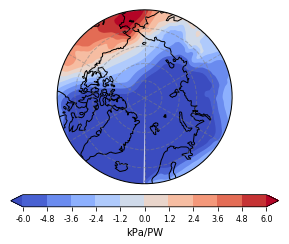

In [7]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + 60N & SLP + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=15, obj='detrend')
    SLP_season_series = meta.statistics.operator.seasons(SLP_ERAI[:],
                                                         span=lag_winter[lag])
    stat_SLP_ERAI = meta.statistics.operator(SLP_season_series[3:,:,:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_SLP_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_SLP_ERAI._detrend)
    ticks = np.linspace(-6,6,11)
    label = 'kPa/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k/1000, p_real, label, ticks,
                                   os.path.join(output_path, 'ORAS4', 'season',
                                   'spatial_ORAS4_OMET_60N_lag_{}_ERAI_SLP_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')  

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + 60N & SIC + winter (DJF)  ====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


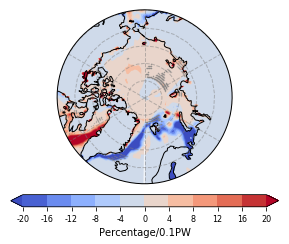

In [8]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + 60N & SIC + winter (DJF)  ====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)        
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(SIC_ERAI[:],
                                                         span=lag_winter[lag])
    stat_SIC_ERAI = meta.statistics.operator(SIC_season_series[3:,:,:])
    stat_SIC_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI.detrend()
    stat_SIC_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_SIC_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_SIC_ERAI._detrend)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = np.linspace(-20,20,11)
    label = 'Percentage/0.1PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k*10, p_real, label, ticks,
                                   os.path.join(output_path, 'ORAS4', 'season',
                                   'spatial_ORAS4_OMET_60N_lag_{}_ERAI_SIC_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', decimal="%d", ttest='dot')  

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + 60N & T2M + winter (DJF)  ====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


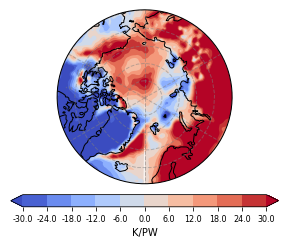

In [9]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + 60N & T2M + winter (DJF)  ====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)        
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=15, obj='detrend')
    T2M_season_series = meta.statistics.operator.seasons(T2M_ERAI[:],
                                                         span=lag_winter[lag], Dim_month=True)
    stat_T2M_ERAI = meta.statistics.operator(T2M_season_series[3:])
    stat_T2M_ERAI.anomaly(Dim_month=False)
    stat_T2M_ERAI.detrend()
    stat_T2M_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_T2M_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_T2M_ERAI._detrend)
    ticks = np.linspace(-30,30,11)
    label = 'K/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k, p_real, label, ticks,
                                   os.path.join(output_path, 'ORAS4', 'season',
                                   'spatial_ORAS4_OMET_60N_lag_{}_ERAI_T2M_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')  

***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********
======================   OMET + 60N & SLP + winter (DJF)   =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


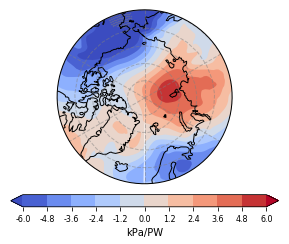

In [10]:
    print ('***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********')
    print ('======================   OMET + 60N & SLP + winter (DJF)   =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_GLORYS2V3[:,:,209],
                                                          span='DJF', Dim_month=True)   
    stat_OMET_GLORYS2V3 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_GLORYS2V3.anomaly(Dim_month=False)
    stat_OMET_GLORYS2V3.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_GLORYS2V3.lowpass(window=15, obj='detrend')
    SLP_season_series = meta.statistics.operator.seasons(SLP_ERAI[168:-24,:,:],
                                                         span=lag_winter[lag])
    stat_SLP_ERAI = meta.statistics.operator(SLP_season_series[3:,:,:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._lowpass,
                                                     stat_SLP_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._detrend,
                                                          stat_SLP_ERAI._detrend)
    ticks = np.linspace(-6,6,11)
    label = 'kPa/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k/1000, p_real, label, ticks,
                                   os.path.join(output_path, 'GLORYS2V3', 'season',
                                   'spatial_GLORYS2V3_OMET_60N_lag_{}_ERAI_SLP_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')

***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********
======================   OMET + 60N & SIC + winter (DJF)   =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


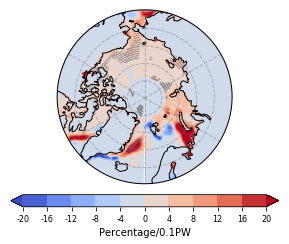

In [11]:
    print ('***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********')
    print ('======================   OMET + 60N & SIC + winter (DJF)   =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_GLORYS2V3[:,:,209],
                                                          span='DJF', Dim_month=True)   
    stat_OMET_GLORYS2V3 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_GLORYS2V3.anomaly(Dim_month=False)
    stat_OMET_GLORYS2V3.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_GLORYS2V3.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(SIC_ERAI[168:-24,:,:],
                                                         span=lag_winter[lag])
    stat_SIC_ERAI = meta.statistics.operator(SIC_season_series[3:,:,:])
    stat_SIC_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI.detrend()
    stat_SIC_ERAI.lowpass(window=15, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._lowpass,
                                                     stat_SIC_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._detrend,
                                                          stat_SIC_ERAI._detrend)
    ticks = np.linspace(-20,20,11)
    label = 'Percentage/0.1PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k*10, p_real, label, ticks,
                                   os.path.join(output_path, 'GLORYS2V3', 'season',
                                   'spatial_GLORYS2V3_OMET_60N_lag_{}_ERAI_SIC_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', decimal="%d",  ttest='dot')

***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********
======================   OMET + 60N & T2M + winter (DJF) =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


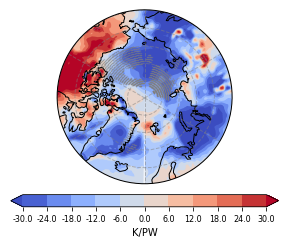

In [12]:
    print ('***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********')
    print ('======================   OMET + 60N & T2M + winter (DJF) =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_GLORYS2V3[:,:,209],
                                                          span='DJF', Dim_month=True)   
    stat_OMET_GLORYS2V3 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_GLORYS2V3.anomaly(Dim_month=False)
    stat_OMET_GLORYS2V3.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_GLORYS2V3.lowpass(window=15, obj='detrend')
    T2M_season_series = meta.statistics.operator.seasons(T2M_ERAI[14:-2,:,:,:],
                                                         span=lag_winter[lag], Dim_month=True)
    stat_T2M_ERAI = meta.statistics.operator(T2M_season_series[3:])
    stat_T2M_ERAI.anomaly(Dim_month=False)
    stat_T2M_ERAI.detrend()
    stat_T2M_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._lowpass,
                                                     stat_T2M_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._detrend,
                                                          stat_T2M_ERAI._detrend)
    ticks = np.linspace(-30,30,11)
    label = 'K/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k, p_real, label, ticks,
                                   os.path.join(output_path, 'GLORYS2V3', 'season',
                                   'spatial_GLORYS2V3_OMET_60N_lag_{}_ERAI_T2M_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')

***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********
====================  OMET + 60N & SLP + winter (DJF)  ====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


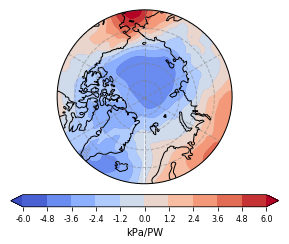

In [13]:
    print ('***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********')
    print ('====================  OMET + 60N & SLP + winter (DJF)  ====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_SODA3[:,:,220],
                                                          span='DJF', Dim_month=True)  
    stat_OMET_SODA3 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_SODA3.anomaly(Dim_month=False)
    stat_OMET_SODA3.detrend()
    stat_OMET_SODA3.lowpass(window=15, obj='detrend')
    SLP_season_series = meta.statistics.operator.seasons(SLP_ERAI[12:-12,:,:],
                                                         span=lag_winter[lag])
    stat_SLP_ERAI = meta.statistics.operator(SLP_season_series[3:,:,:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=15, obj='detrend')
    
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_SODA3._lowpass,
                                                     stat_SLP_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_SODA3._detrend,
                                                          stat_SLP_ERAI._detrend)
    ticks = np.linspace(-6,6,11)
    label = 'kPa/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k/1000, p_real, label, ticks,
                                   os.path.join(output_path, 'SODA3', 'season',
                                   'spatial_SODA3_OMET_60N_lag_{}_ERAI_SLP_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')

***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********
====================  OMET + 60N & SIC + winter (DJF)  ====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


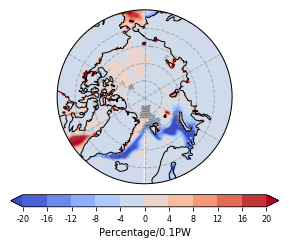

In [14]:
    print ('***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********')
    print ('====================  OMET + 60N & SIC + winter (DJF)  ====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_SODA3[:,:,220],
                                                          span='DJF', Dim_month=True)  
    stat_OMET_SODA3 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_SODA3.anomaly(Dim_month=False)
    stat_OMET_SODA3.detrend()
    stat_OMET_SODA3.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(SIC_ERAI[12:-12,:,:],
                                                         span=lag_winter[lag])
    stat_SIC_ERAI = meta.statistics.operator(SIC_season_series[3:,:,:])
    stat_SIC_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI.detrend()
    stat_SIC_ERAI.lowpass(window=15, obj='detrend')
    
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_SODA3._lowpass,
                                                     stat_SIC_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_SODA3._detrend,
                                                          stat_SIC_ERAI._detrend)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = np.linspace(-20,20,11)
    label = 'Percentage/0.1PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k*10, p_real, label, ticks,
                                   os.path.join(output_path, 'SODA3', 'season',
                                   'spatial_SODA3_OMET_60N_lag_{}_ERAI_SIC_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', decimal="%d", ttest='dot')

***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********
====================  OMET + 60N & T2M + winter (DJF)  ====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


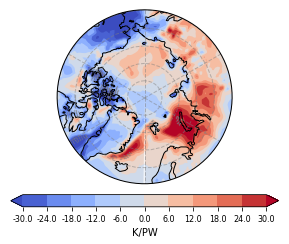

In [15]:
    print ('***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********')
    print ('====================  OMET + 60N & T2M + winter (DJF)  ====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_SODA3[:,:,220],
                                                          span='DJF', Dim_month=True)  
    stat_OMET_SODA3 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_SODA3.anomaly(Dim_month=False)
    stat_OMET_SODA3.detrend()
    stat_OMET_SODA3.lowpass(window=15, obj='detrend')
    T2M_season_series = meta.statistics.operator.seasons(T2M_ERAI[1:-1,:,:,:],
                                                         span=lag_winter[lag], Dim_month=True)
    stat_T2M_ERAI = meta.statistics.operator(T2M_season_series[3:])
    stat_T2M_ERAI.anomaly(Dim_month=False)
    stat_T2M_ERAI.detrend()
    stat_T2M_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_SODA3._lowpass,
                                                     stat_T2M_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_SODA3._detrend,
                                                          stat_T2M_ERAI._detrend)
    ticks = np.linspace(-30,30,11)
    label = 'K/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k, p_real, label, ticks,
                                   os.path.join(output_path, 'SODA3', 'season',
                                   'spatial_SODA3_OMET_60N_lag_{}_ERAI_T2M_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')

Be cautious about the time across the year! The definition of sign is a bit different from others. Negative means the climatology leads.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + 60N & SLP + summer (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


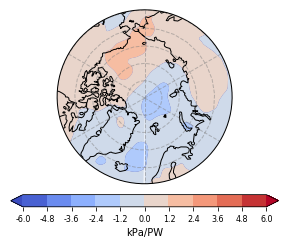

In [16]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + 60N & SLP + summer (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_ORAS4[:,:,53],
                                                          span='JJA', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[:])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=15, obj='detrend')
    SLP_season_series = meta.statistics.operator.seasons(SLP_ERAI[:],
                                                         span=lag_summer[lag])
    stat_SLP_ERAI = meta.statistics.operator(SLP_season_series[:,:,:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_SLP_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_SLP_ERAI._detrend)
    ticks = np.linspace(-6,6,11)
    label = 'kPa/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k/1000, p_real, label, ticks,
                                   os.path.join(output_path, 'ORAS4', 'season',
                                   'spatial_ORAS4_OMET_60N_lag_{}_ERAI_SLP_JJA_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')  

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + 60N & SIC + summer (JJA)  ====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


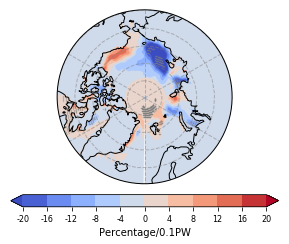

In [17]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + 60N & SIC + summer (JJA)  ====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_ORAS4[:,:,53],
                                                          span='JJA', Dim_month=True)        
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[:])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(SIC_ERAI[:],
                                                         span=lag_summer[lag])
    stat_SIC_ERAI = meta.statistics.operator(SIC_season_series[:,:,:])
    stat_SIC_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI.detrend()
    stat_SIC_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_SIC_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_SIC_ERAI._detrend)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = np.linspace(-20,20,11)
    label = 'Percentage/0.1PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k*10, p_real, label, ticks,
                                   os.path.join(output_path, 'ORAS4', 'season',
                                   'spatial_ORAS4_OMET_60N_lag_{}_ERAI_SIC_JJA_interannual.png'.format(lag)),
                                   boundary='polarcap', decimal="%d", ttest='dot')  

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + 60N & T2M + summer (JJA)  ====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


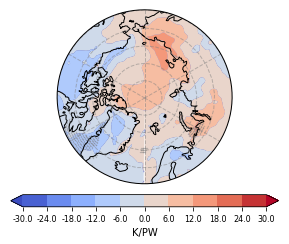

In [18]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + 60N & T2M + summer (JJA)  ====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_ORAS4[:,:,53],
                                                          span='JJA', Dim_month=True)        
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[:])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=15, obj='detrend')
    T2M_season_series = meta.statistics.operator.seasons(T2M_ERAI[:],
                                                         span=lag_summer[lag], Dim_month=True)
    stat_T2M_ERAI = meta.statistics.operator(T2M_season_series[:])
    stat_T2M_ERAI.anomaly(Dim_month=False)
    stat_T2M_ERAI.detrend()
    stat_T2M_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_T2M_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_T2M_ERAI._detrend)
    ticks = np.linspace(-30,30,11)
    label = 'K/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k, p_real, label, ticks,
                                   os.path.join(output_path, 'ORAS4', 'season',
                                   'spatial_ORAS4_OMET_60N_lag_{}_ERAI_T2M_JJA_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')  

***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********
======================   OMET + 60N & SLP + summer (JJA)   =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


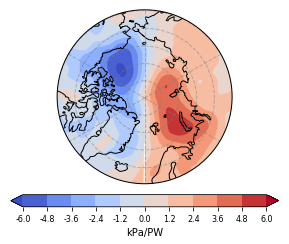

In [19]:
    print ('***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********')
    print ('======================   OMET + 60N & SLP + summer (JJA)   =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_GLORYS2V3[:,:,209],
                                                          span='JJA', Dim_month=True)   
    stat_OMET_GLORYS2V3 = meta.statistics.operator(OMET_season_series[:])
    stat_OMET_GLORYS2V3.anomaly(Dim_month=False)
    stat_OMET_GLORYS2V3.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_GLORYS2V3.lowpass(window=15, obj='detrend')
    SLP_season_series = meta.statistics.operator.seasons(SLP_ERAI[168:-24,:,:],
                                                         span=lag_summer[lag])
    stat_SLP_ERAI = meta.statistics.operator(SLP_season_series[:,:,:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._lowpass,
                                                     stat_SLP_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._detrend,
                                                          stat_SLP_ERAI._detrend)
    ticks = np.linspace(-6,6,11)
    label = 'kPa/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k/1000, p_real, label, ticks,
                                   os.path.join(output_path, 'GLORYS2V3', 'season',
                                   'spatial_GLORYS2V3_OMET_60N_lag_{}_ERAI_SLP_JJA_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')

***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********
======================   OMET + 60N & SIC + summer (JJA)   =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


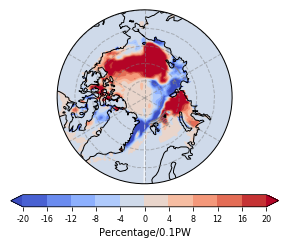

In [20]:
    print ('***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********')
    print ('======================   OMET + 60N & SIC + summer (JJA)   =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_GLORYS2V3[:,:,209],
                                                          span='JJA', Dim_month=True)   
    stat_OMET_GLORYS2V3 = meta.statistics.operator(OMET_season_series[:])
    stat_OMET_GLORYS2V3.anomaly(Dim_month=False)
    stat_OMET_GLORYS2V3.detrend()
    stat_OMET_GLORYS2V3.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(SIC_ERAI[168:-24,:,:],
                                                         span=lag_summer[lag])
    stat_SIC_ERAI = meta.statistics.operator(SIC_season_series[:,:,:])
    stat_SIC_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI.detrend()
    stat_SIC_ERAI.lowpass(window=15, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._lowpass,
                                                     stat_SIC_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._detrend,
                                                          stat_SIC_ERAI._detrend)
    ticks = np.linspace(-20,20,11)
    label = 'Percentage/0.1PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k*10, p_real, label, ticks,
                                   os.path.join(output_path, 'GLORYS2V3', 'season',
                                   'spatial_GLORYS2V3_OMET_60N_lag_{}_ERAI_SIC_JJA_interannual.png'.format(lag)),
                                   boundary='polarcap', decimal="%d", ttest='dot')

***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********
======================   OMET + 60N & T2M + summer (JJA) =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


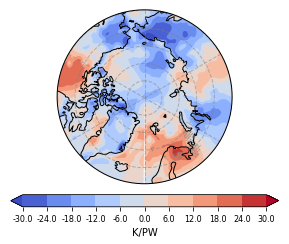

In [21]:
    print ('***********!@#$%^&*     Lead/ Lag regression of GLORYS2V3   !@#$%^&***********')
    print ('======================   OMET + 60N & T2M + summer (JJA) =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_GLORYS2V3[:,:,209],
                                                          span='JJA', Dim_month=True)   
    stat_OMET_GLORYS2V3 = meta.statistics.operator(OMET_season_series[:])
    stat_OMET_GLORYS2V3.anomaly(Dim_month=False)
    stat_OMET_GLORYS2V3.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_GLORYS2V3.lowpass(window=15, obj='detrend')
    T2M_season_series = meta.statistics.operator.seasons(T2M_ERAI[14:-2,:,:,:],
                                                         span=lag_summer[lag], Dim_month=True)
    stat_T2M_ERAI = meta.statistics.operator(T2M_season_series[:])
    stat_T2M_ERAI.anomaly(Dim_month=False)
    stat_T2M_ERAI.detrend()
    stat_T2M_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._lowpass,
                                                     stat_T2M_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_GLORYS2V3._detrend,
                                                          stat_T2M_ERAI._detrend)
    ticks = np.linspace(-30,30,11)
    label = 'K/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k, p_real, label, ticks,
                                   os.path.join(output_path, 'GLORYS2V3', 'season',
                                   'spatial_GLORYS2V3_OMET_60N_lag_{}_ERAI_T2M_JJA_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')

***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********
====================  OMET + 60N & SLP + summer (JJA)  ====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


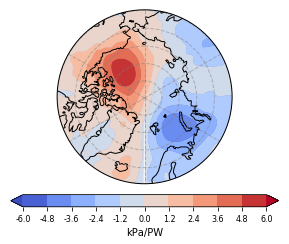

In [22]:
    print ('***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********')
    print ('====================  OMET + 60N & SLP + summer (JJA)  ====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_SODA3[:,:,220],
                                                          span='JJA', Dim_month=True)  
    stat_OMET_SODA3 = meta.statistics.operator(OMET_season_series[:])
    stat_OMET_SODA3.anomaly(Dim_month=False)
    stat_OMET_SODA3.detrend()
    stat_OMET_SODA3.lowpass(window=15, obj='detrend')
    SLP_season_series = meta.statistics.operator.seasons(SLP_ERAI[12:-12,:,:],
                                                         span=lag_summer[lag])
    stat_SLP_ERAI = meta.statistics.operator(SLP_season_series[:,:,:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=15, obj='detrend')
    
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_SODA3._lowpass,
                                                     stat_SLP_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_SODA3._detrend,
                                                          stat_SLP_ERAI._detrend)
    ticks = np.linspace(-6,6,11)
    label = 'kPa/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k/1000, p_real, label, ticks,
                                   os.path.join(output_path, 'SODA3', 'season',
                                   'spatial_SODA3_OMET_60N_lag_{}_ERAI_SLP_JJA_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')

***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********
====================  OMET + 60N & SIC + summer (JJA)  ====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


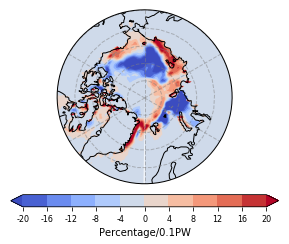

In [23]:
    print ('***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********')
    print ('====================  OMET + 60N & SIC + summer (JJA)  ====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_SODA3[:,:,220],
                                                          span='JJA', Dim_month=True)  
    stat_OMET_SODA3 = meta.statistics.operator(OMET_season_series[:])
    stat_OMET_SODA3.anomaly(Dim_month=False)
    stat_OMET_SODA3.detrend()
    stat_OMET_SODA3.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(SIC_ERAI[12:-12,:,:],
                                                         span=lag_summer[lag])
    stat_SIC_ERAI = meta.statistics.operator(SIC_season_series[:,:,:])
    stat_SIC_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI.detrend()
    stat_SIC_ERAI.lowpass(window=15, obj='detrend')
    
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_SODA3._lowpass,
                                                     stat_SIC_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_SODA3._detrend,
                                                          stat_SIC_ERAI._detrend)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = np.linspace(-20,20,11)
    label = 'Percentage/0.1PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k*10, p_real, label, ticks,
                                   os.path.join(output_path, 'SODA3', 'season',
                                   'spatial_SODA3_OMET_60N_lag_{}_ERAI_SIC_JJA_interannual.png'.format(lag)),
                                   boundary='polarcap', decimal="%d", ttest='dot')

***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********
====================  OMET + 60N & T2M + summer (JJA)  ====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


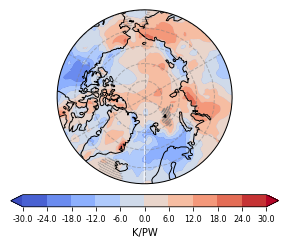

In [24]:
    print ('***********!@#$%^&*     Lead/ Lag regression of SODA3   !@#$%^&***********')
    print ('====================  OMET + 60N & T2M + summer (JJA)  ====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_SODA3[:,:,220],
                                                          span='JJA', Dim_month=True)  
    stat_OMET_SODA3 = meta.statistics.operator(OMET_season_series[:])
    stat_OMET_SODA3.anomaly(Dim_month=False)
    stat_OMET_SODA3.detrend()
    stat_OMET_SODA3.lowpass(window=15, obj='detrend')
    T2M_season_series = meta.statistics.operator.seasons(T2M_ERAI[1:-1,:,:,:],
                                                         span=lag_summer[lag], Dim_month=True)
    stat_T2M_ERAI = meta.statistics.operator(T2M_season_series[:])
    stat_T2M_ERAI.anomaly(Dim_month=False)
    stat_T2M_ERAI.detrend()
    stat_T2M_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_SODA3._lowpass,
                                                     stat_T2M_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_SODA3._detrend,
                                                          stat_T2M_ERAI._detrend)
    ticks = np.linspace(-30,30,11)
    label = 'K/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k, p_real, label, ticks,
                                   os.path.join(output_path, 'SODA3', 'season',
                                   'spatial_SODA3_OMET_60N_lag_{}_ERAI_T2M_JJA_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='dot')